# Computational Neuroscience

## Lecture 2: Hodgkin-Huxley model

Experimentally fitted to data recorded from the Giant Squid Axon.

$$
\sum_k I_k = g_{Na} m^3 h (u - E_{Na}) + g_k n^4 (u - E_K) + g_L (u - E_L) \\
\dot m = \alpha_m (u) \cdot (1-m) - \beta_m (u) \cdot m \\
\dot n = \alpha_n (u) \cdot (1-n) - \beta_n (u) \cdot n \\
\dot h = \alpha_h (u) \cdot (1-h) - \beta_h (u) \cdot h \\
$$

s.t. $k_{t+\Delta t} = k_t + \Delta t \cdot (\alpha_h (u) \cdot (1-h) - \beta_h (u) \cdot h)$

where

$$
C \frac{\text{d} u}{\text{d} t} = I(t) - \sum_k I_k(t) \tilde = C \frac{u_{t+\Delta t} - u_{t}}{\Delta t} \\
u_{t+\Delta t} = \frac{I(t) - \sum_k I_k(t)}{C} + u_t
$$

Probabilistic interpretation of $n$ and $m$ is the mean of the Bernoulli variable modeling each ion channel.

### Defintion of constants

Note the use of the fixed offset voltage of -65 mV. This may be set to 0 mV as well.

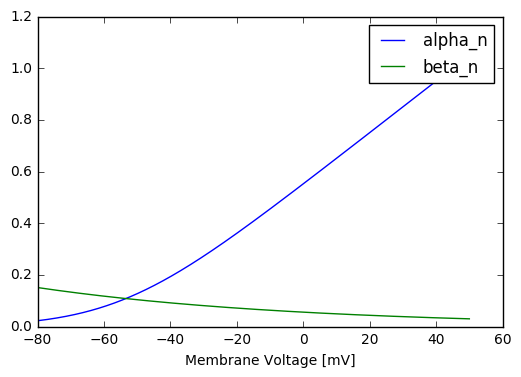

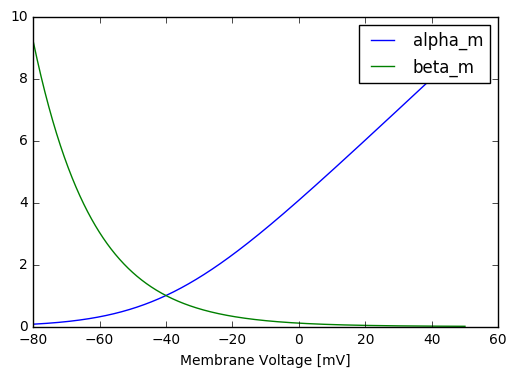

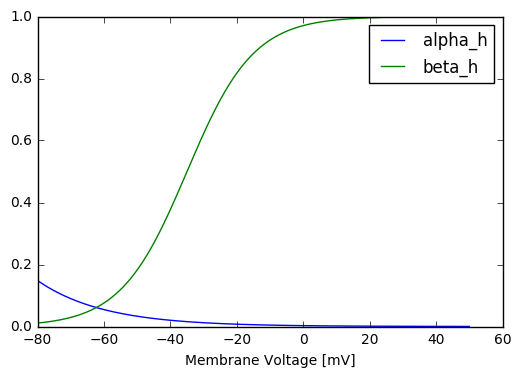

In [4]:
import numpy as np
from pylab import *
%matplotlib inline

# Offset voltage level
u_off = -65

# Sodium: m³ is probability, h gating variable
α_m = lambda u: (2.5 - 0.1*(u - u_off)) / (np.exp(2.5 - 0.1*(u - u_off)) - 1)
β_m  = lambda u : 4*np.exp(-(u - u_off)/18)
α_h = lambda u: 0.07 * np.exp(-(u - u_off)/20)
β_h  = lambda u : 1/(np.exp(3 - 0.1*(u - u_off))+1)
g_Na = 120
E_Na = 115 + u_off

# Potassium: n^4 is the probability
α_n = lambda u: (0.1 - 0.01*(u - u_off)) / (np.exp(1-0.1*(u - u_off))-1)
β_n  = lambda u : 0.125 * np.exp(-(u - u_off)/80)
g_K = 36
E_K = -12 + u_off

# Everything else is covered by E_L
g_L = 0.3
E_L = 10.6 + u_off

uu = np.linspace(-80, 50, 1000)

plot(uu, α_n(uu), label="alpha_n")
plot(uu, β_n(uu), label="beta_n")
legend()
xlabel("Membrane Voltage [mV]")
show()

plot(uu, α_m(uu), label="alpha_m")
plot(uu, β_m(uu), label="beta_m")
legend()
xlabel("Membrane Voltage [mV]")
show()

plot(uu, α_h(uu), label="alpha_h")
plot(uu, β_h(uu), label="beta_h")
legend()
xlabel("Membrane Voltage [mV]")
show()

## Compute membrane voltage

The following function takes an input current $I_{in}$ and computes the transient output membrane voltage from it.

In [5]:
ddt    = lambda alpha, beta, u, last : alpha(u) * (1 - last) - beta(u) * last
update = lambda alpha, beta, u, last, dt : ddt(alpha,  beta, u, last) * dt + last

def compute(I_in, dt=0.001, initial=None):
    nb_samples, = I_in.shape
    
    u_t = np.zeros_like(I_in)
    I_out = np.zeros_like(I_in)
    nn = np.zeros_like(I_in)
    mm = np.zeros_like(I_in)
    hh = np.zeros_like(I_in)
    
    if initial is not None:
        u, n, m, h = initial
    else:
        u = u_off

        n = ddt(α_n, β_n, u, 0)/(ddt(α_n, β_n, u, 0)-ddt(α_n, β_n, u, 1))
        m = ddt(α_m, β_m, u, 0)/(ddt(α_m, β_m, u, 0)-ddt(α_m, β_m, u, 1))
        h = ddt(α_h, β_h, u, 0)/(ddt(α_h, β_h, u, 0)-ddt(α_h, β_h, u, 1))
    
    #print(n,m,h)
    
    u_t[0] = u
    C = 0.5
    
    for i in range(1, nb_samples):
        I = g_Na * m**3 * h * (u - E_Na) + g_K * n**4 * (u - E_K) + g_L * (u - E_L)
        
        n = update(α_n, β_n, u, n, dt)
        m = update(α_m, β_m, u, m, dt)
        h = update(α_h, β_h, u, h, dt)
        
        u = (I_in[i-1] - I_out[i-1]) / C * dt + u_t[i-1]
        
        nn[i], mm[i], hh[i], u_t[i], I_out[i] = n, m, h, u, I
    
    return u_t, I_out, nn, mm, hh

# Reproducing boundary plot from lecture

General setting: Initialize model with current $I_2$ and apply a step $I_1 - I_2$ after 50ms for a total length of 100ms.

Classify the output according to three types:
    1. Single Spike (S)
    2. Spike with frequency (R)
    3. Vanishing Transient (I)
    
Ranges for each value are $I_2 \in [0, 10]$ and $\Delta I \in [0, 6]$.

### First experiment: Pulses with increasing magnitude

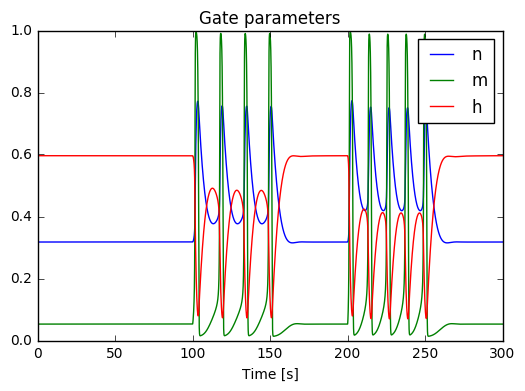

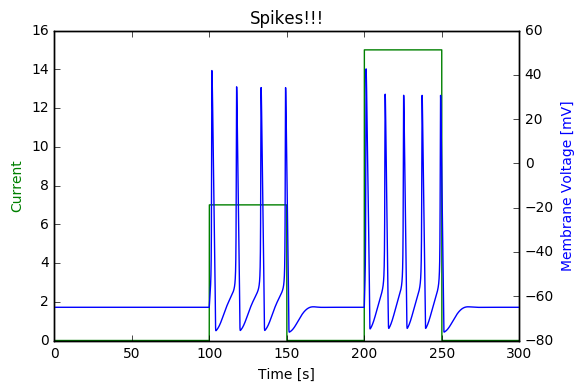

In [7]:
total_time = 300
dt = 0.01

nb_samples = int(total_time / dt)

tt = np.linspace(0, total_time, nb_samples)
I_in = np.zeros((nb_samples,))
timeslice = lambda start, end : slice(int(start/dt), int(end/dt))

 
I_in[timeslice(100,150)] = 7
I_in[timeslice(200,250)] = 15

u, I_out, n, m, h = compute(I_in, dt)

# ----------- plotting ---------------- #

plot(tt, n, label="n")
plot(tt, m, label="m")
plot(tt, h, label="h")
xlabel("Time [s]")
legend()
title("Gate parameters")
show()

fig, ax1 = subplots()

ax2 = ax1.twinx()
ax1.plot(tt, I_in, 'g-')
ax2.plot(tt, u, 'b-')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Current', color='g')
ax2.set_ylabel('Membrane Voltage [mV]', color='b')
ax2.set_ylim([-80, 60])
title("Spikes!!!")
show()

## Demonstration of "rebound spikes" caused by hyperpolarization

Note: Neurons react to a _change_ in input current

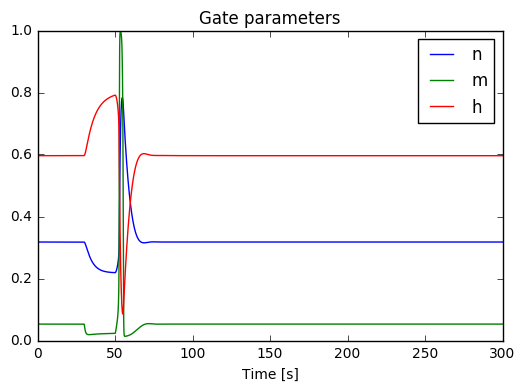

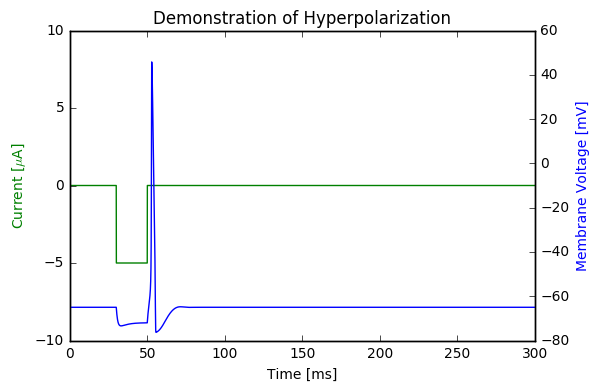

In [8]:
total_time = 300 #s
dt = 0.01
nb_samples = int(total_time / dt)

tt = np.linspace(0, total_time, nb_samples)
I_in = np.zeros((nb_samples,))
timeslice = lambda start, end : slice(int(start/dt), int(end/dt))

I_in[timeslice(30,50)] = -5

u, I_out, n, m, h = compute(I_in, dt)

# ----------- plotting ---------------- #

plot(tt, n, label="n")
plot(tt, m, label="m")
plot(tt, h, label="h")
xlabel("Time [s]")
legend()
title("Gate parameters")
show()

fig, ax1 = subplots()

ax2 = ax1.twinx()
ax1.plot(tt, I_in, 'g-')
ax2.plot(tt, u, 'b-')

ax1.set_xlabel('Time [ms]')
ax1.set_ylabel('Current [$\mu$A]', color='g')
ax2.set_ylabel('Membrane Voltage [mV]', color='b')
ax1.set_ylim([-10, 10])
ax2.set_ylim([-80, 60])
title("Demonstration of Hyperpolarization")
show()

In [9]:
def simulate_and_plot(total_time = 300, dt = 0.01, I_func=lambda t:0, plot_title=""):
    """ Plot results
    """
                      
    nb_samples = int(total_time / dt)

    tt = np.linspace(0, total_time, nb_samples)
    I_in = np.zeros((nb_samples,))
    timeslice = lambda start, end : slice(int(start/dt), int(end/dt))

    I_in[timeslice(30,200)] = 5

    u, I_out, n, m, h = compute(I_in, dt)

    # ----------- plotting ---------------- #

    plot(tt, n, label="n")
    plot(tt, m, label="m")
    plot(tt, h, label="h")
    xlabel("Time [s]")
    legend()
    title("Gate parameters")
    show()

    fig, ax1 = subplots()

    ax2 = ax1.twinx()
    ax1.plot(tt, I_in, 'g-')
    ax2.plot(tt, u, 'b-')

    ax1.set_xlabel('Time [ms]')
    ax1.set_ylabel('Current [µV]', color='g')
    ax2.set_ylabel('Membrane Voltage [mV]', color='b')
    ax2.set_ylim([-80, 60])
    title(plot_title)
    show()

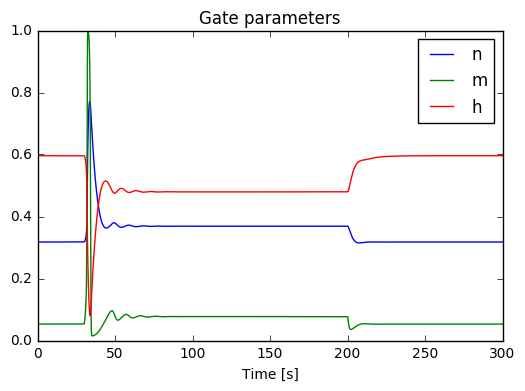

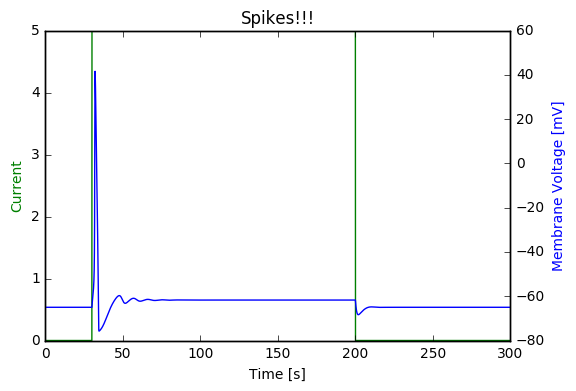

In [10]:
total_time = 300 #s
dt = 0.01
nb_samples = int(total_time / dt)

tt = np.linspace(0, total_time, nb_samples)
I_in = np.zeros((nb_samples,))
timeslice = lambda start, end : slice(int(start/dt), int(end/dt))

I_in[timeslice(30,200)] = 5

u, I_out, n, m, h = compute(I_in, dt)

# ----------- plotting ---------------- #

plot(tt, n, label="n")
plot(tt, m, label="m")
plot(tt, h, label="h")
xlabel("Time [s]")
legend()
title("Gate parameters")
show()

fig, ax1 = subplots()

ax2 = ax1.twinx()
ax1.plot(tt, I_in, 'g-')
ax2.plot(tt, u, 'b-')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Current', color='g')
ax2.set_ylabel('Membrane Voltage [mV]', color='b')
ax2.set_ylim([-80, 60])
title("Spikes!!!")
show()

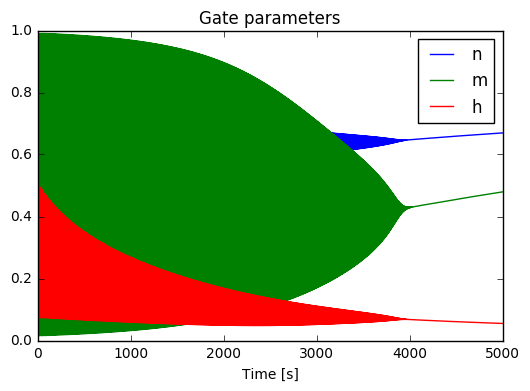

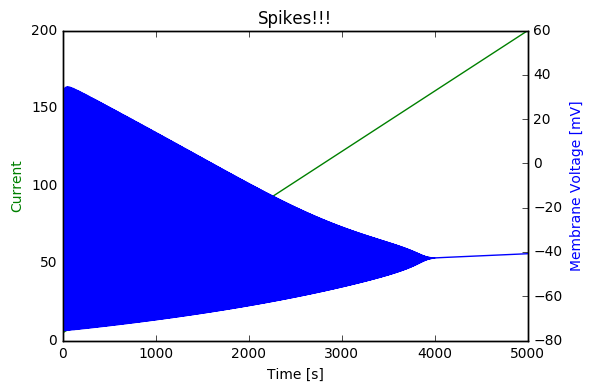

0.669586293316 0.47942198967 0.0549949149848


In [11]:
total_time = 5000 #s
dt = 0.01
nb_samples = int(total_time / dt)

tt = np.linspace(0, total_time, nb_samples)
I_in = np.zeros((nb_samples,))
timeslice = lambda start, end : slice(int(start/dt), int(end/dt))

I_in = np.linspace(5, 200, nb_samples)
u, I_out, n, m, h = compute(I_in, dt)

# ----------- plotting ---------------- #

plot(tt, n, label="n")
plot(tt, m, label="m")
plot(tt, h, label="h")
xlabel("Time [s]")
legend()
title("Gate parameters")
show()

fig, ax1 = subplots()

ax2 = ax1.twinx()
ax1.plot(tt, I_in, 'g-')
ax2.plot(tt, u, 'b-')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Current', color='g')
ax2.set_ylabel('Membrane Voltage [mV]', color='b')
ax2.set_ylim([-80, 60])
title("Spikes!!!")
show()

print(n[-1],m[-1],h[-1])

# Compute spike frequency over time (Activation Function)

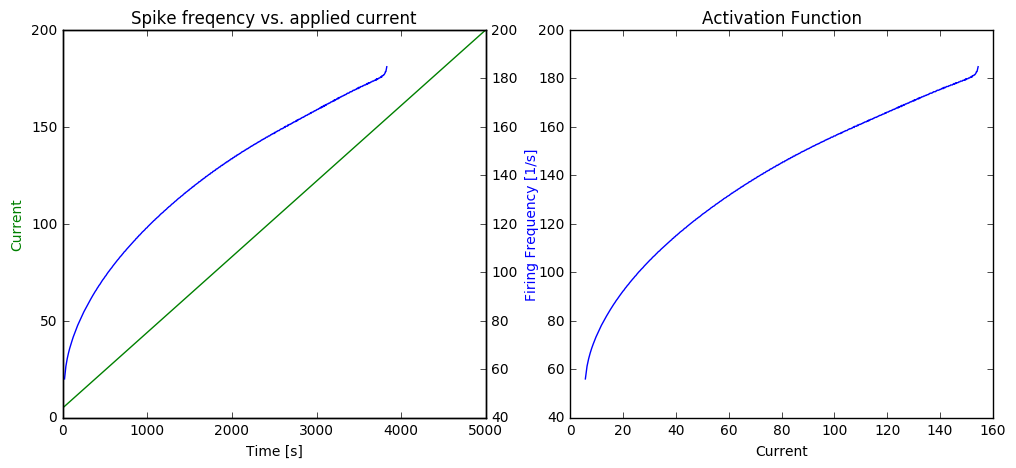

In [21]:
spikes = 1*(u > -45)
spikes = (spikes[1:] - spikes[0:-1]) > 0
dts = tt[1:][spikes]
ddts = dts[1:] - dts[0:-1]

fig, axes = subplots(1,2, figsize=(12,5))

ax1 = axes[0]
ax2 = ax1.twinx()
ax1.plot(tt, I_in, 'g-')
ax2.plot(dts[1:], 1000/ddts, 'b-')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Current', color='g')
ax2.set_ylabel("Firing Frequency [1/s]", color="b")
ax2.set_title("Spike freqency vs. applied current")

ax3 = axes[1]
ax3.plot(I_in[1:][spikes][1:], 1000/ddts)
ax3.set_xlabel("Current")
ax3.set_title("Activation Function")

show()

# Lecture 3

## Conductance based models

Changes in membrane conductances lead to changes in mebrane potential:

$$
u_m(g_{Na}, g_K) = \frac{E_k + E_{Na} \frac{g_{Na}}{g_K}}{1 + \frac{g_{Na}}{g_K}}
$$

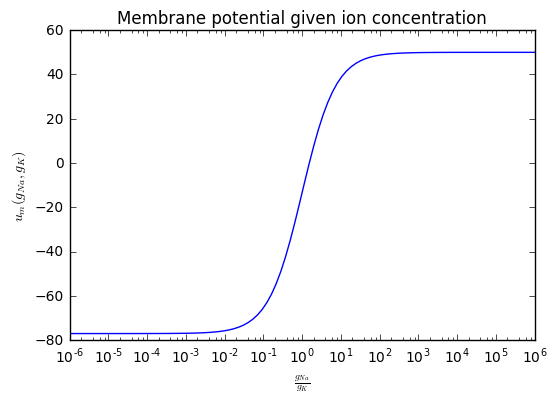

In [22]:
u = lambda E_K, E_Na, ratio : (E_K + E_Na * ratio) / (1 + ratio)

xx = np.logspace(-6, 6, 100)

semilogx(xx, u(E_K, E_Na, xx))
xlabel("$\\frac{g_{Na}}{g_K}$")
ylabel("$u_m(g_{Na}, g_K)$")
title("Membrane potential given ion concentration")
show()

## Lecture 3: Relaxed Version of Hodgkin-Huxley Model

$$
\sum_k I_k = g_{Na} m^3 h (u - E_{Na}) + g_k n^4 (u - E_K) + g_L (u - E_L) \\
\dot w = \alpha_m (u) \cdot (1-w) - \beta_m (u) \cdot w \\
m = w \\
h = (1-w)
$$

s.t. $k_{t+\Delta t} = k_t + \Delta t \cdot (\alpha_h (u) \cdot (1-h) - \beta_h (u) \cdot h)$

where

$$
C \frac{\text{d} u}{\text{d} t} = I(t) - \sum_k I_k(t) \tilde = C \frac{u_{t+\Delta t} - u_{t}}{\Delta t} \\
u_{t+\Delta t} = \frac{I(t) - \sum_k I_k(t)}{C} + u_t
$$

Probabilistic interpretation of $n$ and $m$ is the mean of the Bernoulli variable modeling each ion channel.

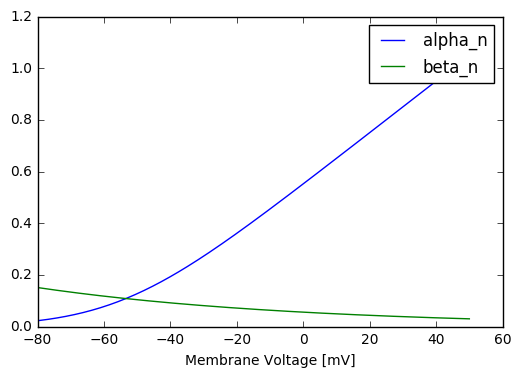

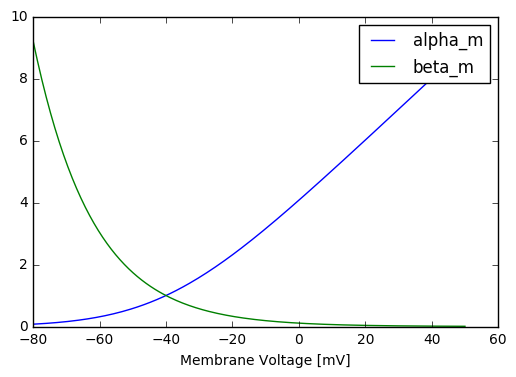

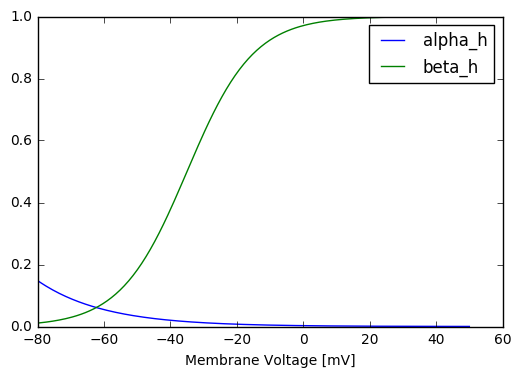

In [23]:
import numpy as np

# Offset voltage level
u_off = -65

# Sodium: m³ is probability, h gating variable
α_m = lambda u: (2.5 - 0.1*(u - u_off)) / (np.exp(2.5 - 0.1*(u - u_off)) - 1)
β_m  = lambda u : 4*np.exp(-(u - u_off)/18)
α_h = lambda u: 0.07 * np.exp(-(u - u_off)/20)
β_h  = lambda u : 1/(np.exp(3 - 0.1*(u - u_off))+1)
g_Na = 120
E_Na = 115 + u_off

# Potassium: n^4 is the probability
α_n = lambda u: (0.1 - 0.01*(u - u_off)) / (np.exp(1-0.1*(u - u_off))-1)
β_n  = lambda u : 0.125 * np.exp(-(u - u_off)/80)
g_K = 36
E_K = -12 + u_off

# Everything else is covered by E_L
g_L = 0.3
E_L = 10.6 + u_off

uu = np.linspace(-80, 50, 200)

plot(uu, α_n(uu), label="alpha_n")
plot(uu, β_n(uu), label="beta_n")
legend()
xlabel("Membrane Voltage [mV]")
show()

plot(uu, α_m(uu), label="alpha_m")
plot(uu, β_m(uu), label="beta_m")
legend()
xlabel("Membrane Voltage [mV]")
show()

plot(uu, α_h(uu), label="alpha_h")
plot(uu, β_h(uu), label="beta_h")
legend()
xlabel("Membrane Voltage [mV]")
show()

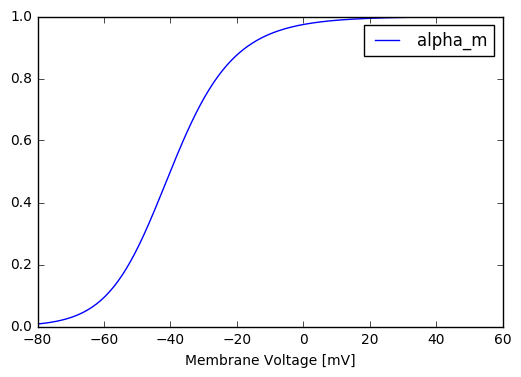

In [24]:
m_steady = lambda u : α_m(u) / (α_m(u) + β_m(u))

plot(uu, m_steady(uu), label="alpha_m")
legend()
xlabel("Membrane Voltage [mV]")
show()

Simplified Hodkin-Huxley model

In [25]:
ddt    = lambda alpha, beta, u, last : alpha(u) * (1 - last) - beta(u) * last
update = lambda alpha, beta, u, last, dt : ddt(alpha,  beta, u, last) * dt + last

def compute(I_in, dt=0.001):
    nb_samples, = I_in.shape
    
    u_t = np.zeros_like(I_in)
    I_out = np.zeros_like(I_in)
    nn = np.zeros_like(I_in)
    mm = np.zeros_like(I_in)
    hh = np.zeros_like(I_in)

    u = u_off

    w = ddt(α_n, β_n, u, 0)/(ddt(α_n, β_n, u, 0)-ddt(α_n, β_n, u, 1))
    n = w
    m = m_steady(u)
    h = 1 - w
    
    u_t[0] = u
    C = 0.5
    
    for i in range(1, nb_samples):
        I = g_Na * m**3 * h * (u - E_Na) + g_K * n**4 * (u - E_K) + g_L * (u - E_L)
        
        w = update(α_n, β_n, u, w, dt)
        n = w
        m = m_steady(u)
        h = 1 - w
        
        u = (I_in[i-1] - I_out[i-1]) / C * dt + u_t[i-1]
        
        nn[i], mm[i], hh[i], u_t[i], I_out[i] = n, m, h, u, I
    
    return u_t, I_out, nn, mm, hh

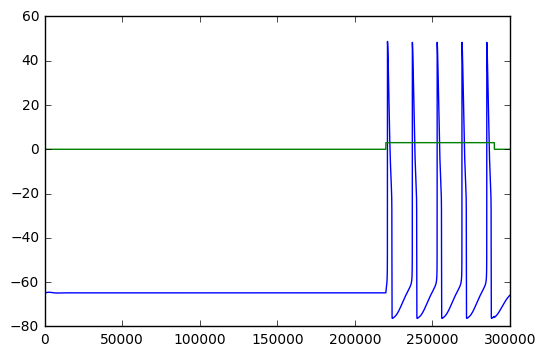

In [26]:
step_on =  220
step_off = 290
sim_time = 300

total_time = sim_time #s
dt = 0.001
nb_samples = int(total_time / dt)

tt = np.linspace(0, total_time, nb_samples)
I_in = np.zeros((nb_samples,))
timeslice = lambda start, end : slice(int(start/dt), int(end/dt))

i2 = 0
di = 3

I_in[timeslice(0,step_on)] = np.linspace(0, i2, step_on/dt)
I_in[timeslice(step_on,step_off)] = i2 + di

u, I_out, n, m, h = compute(I_in, dt)

plot(u)
plot(I_in)
show()

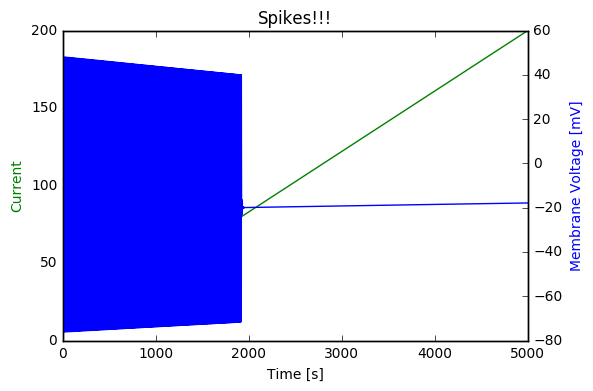

0.845792571656 0.894826652866 0.154207428344


In [27]:
total_time = 5000 #s
dt = 0.001
nb_samples = int(total_time / dt)

tt = np.linspace(0, total_time, nb_samples)
I_in = np.zeros((nb_samples,))
timeslice = lambda start, end : slice(int(start/dt), int(end/dt))

I_in = np.linspace(5, 200, nb_samples)
u, I_out, n, m, h = compute(I_in, dt)

# ----------- plotting ---------------- #

fig, ax1 = subplots()

ax2 = ax1.twinx()
ax1.plot(tt, I_in, 'g-')
ax2.plot(tt, u, 'b-')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Current', color='g')
ax2.set_ylabel('Membrane Voltage [mV]', color='b')
ax2.set_ylim([-80, 60])
title("Spikes!!!")
show()

print(n[-1],m[-1],h[-1])

# Activation function of the Reduced model

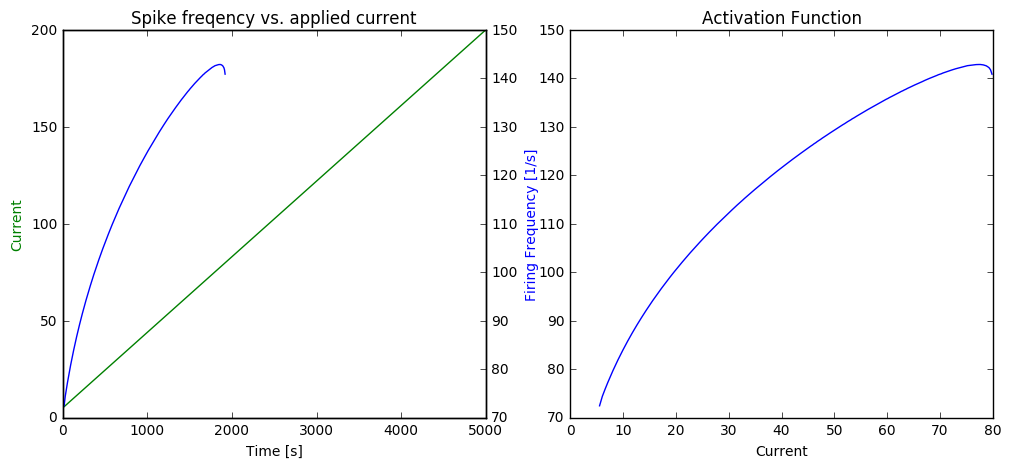

In [31]:
spikes = 1*(u > -45)
spikes = (spikes[1:] - spikes[0:-1]) > 0
dts = tt[1:][spikes]
ddts = dts[1:] - dts[0:-1]

fig, axes = subplots(1,2, figsize=(12,5))

ax1 = axes[0]
ax2 = ax1.twinx()
ax1.plot(tt, I_in, 'g-')
ax2.plot(dts[1:], 1000/ddts, 'b-')

ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Current', color='g')
ax2.set_ylabel("Firing Frequency [1/s]", color="b")
ax2.set_title("Spike freqency vs. applied current")

ax3 = axes[1]
ax3.plot(I_in[1:][spikes][1:], 1000/ddts)
ax3.set_xlabel("Current")
ax3.set_title("Activation Function")

show()